<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30000 non-null  object
 1   label   30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.9+ KB


,text,label
0,Tim Burton is in essence an expressionist film...,1
1,This tale based on two Edgar Allen Poe pieces ...,1
2,"Dead or Alive: Final, the movie that supposedl...",1
3,Certainly this film has the ring of truth abou...,1
4,It pains me to say this about an Australian fi...,0


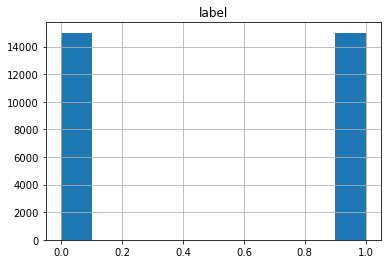

In [1]:
import pandas as pd

df_train = pd.read_json("../data/aclIMDB_train.json", orient='records')
df_train.info()
df_train.hist()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


,text,label
0,This was Barbra Streisand's first television s...,1
1,"I am, as many are, a fan of Tony Scott films. ...",0
2,A young scientist Harry Harrison is continuing...,0
3,"Anthony McGarten has adapted his play, Via Sat...",1
4,"I was watching this movie on Friday,Apr 7th. I...",1


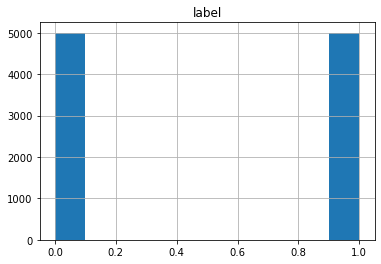

In [2]:
df_val = pd.read_json("../data/aclIMDB_val.json", orient="records")
df_val.info()
df_val.hist()
df_val.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


,text,label
0,This movie features Charlie Spradling dancing ...,0
1,L'Hypothèse du tableau volé/The Hypothesis of ...,1
2,Surprisingly well made little movie. Short in ...,1
3,I rented this because I'm a bit weary of '80s ...,0
4,"Twenty years ago, the five years old boy Micha...",0


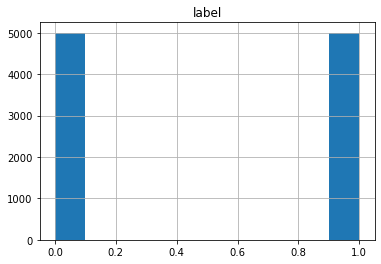

In [3]:
df_test = pd.read_json("../data/aclIMDB_test.json", orient='records')
df_test.info()
df_test.hist()
df_test.head()

In [4]:
train = [str(item).lower() for item in  df_train["text"].values]
val = [str(item).lower() for item in  df_val["text"].values]
test = [str(item).lower() for item in  df_test["text"].values]

In [6]:
import tensorflow as tf

VOCAB_SIZE = 10000

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="UNK")
tokenizer.fit_on_texts(train)

X_train = tokenizer.texts_to_sequences(train)
X_val = tokenizer.texts_to_sequences(val)
X_test = tokenizer.texts_to_sequences(test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 96002 unique tokens.


In [8]:
import numpy as np

maxlen = 128

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)

y_train = np.array(df_train["label"].values)
y_val = np.array(df_val["label"].values)
y_test = np.array(df_test["label"].values)

In [10]:
pip install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9680 sha256=4d91d8c816366256adfb31f238ad2d5c3f5623ed8eec7fe782e5717f5bf8ddca
  Stored in directory: c:\users\opell.desktop-ueq8dpv\appdata\local\pip\cache\wheels\a1\b6\7c\0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
Note: you may need to restart the kernel to use updated packages.


In [13]:
import wget
url = "http://nlp.stanford.edu/data/glove.6B.zip"
path="../data/"
filename = wget.download(url, out=path)

'../data//glove.6B.zip'

In [14]:
import zipfile
with zipfile.ZipFile(filename, "r") as fzip:
    fzip.extractall(path)

In [19]:
embeddings_index = {}
with open("../data/glove.6B.50d.txt", encoding='utf8') as f:
    for line in f:
        word, vector = line.split(maxsplit=1)
        vector = np.fromstring(vector, "f", sep=" ")
        embeddings_index[word] = vector

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [21]:
num_tokens = len(word_index) + 2
embedding_dim = 50
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1

print("Converted %d words (%d misses)" % (hits, misses))

Converted 63422 words (32580 misses)


In [25]:
print("dictionary coverage: ", round(hits / num_tokens * 100),"%")

dictionary coverage:  66 %


In [29]:
import tensorflow as tf

embedding_dim = 50

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(num_tokens, 
                              embedding_dim,                               
                              embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                              trainable=False,
                              input_length=maxlen),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=64),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
]) 

model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['binary_accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 50)           4800200   
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                409664    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 5,209,929
Trainable params: 409,729
Non-trainable params: 4,800,200
_________________________________________________________________


In [34]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_val, y_val))

Epoch 1/20
938/938 [==============================] - 7s 8ms/step - loss: 0.4927 - binary_accuracy: 0.7627 - val_loss: 0.5555 - val_binary_accuracy: 0.7148
Epoch 2/20
938/938 [==============================] - 7s 8ms/step - loss: 0.4865 - binary_accuracy: 0.7670 - val_loss: 0.5715 - val_binary_accuracy: 0.7226
Epoch 3/20
938/938 [==============================] - 7s 8ms/step - loss: 0.4812 - binary_accuracy: 0.7703 - val_loss: 0.5777 - val_binary_accuracy: 0.7135
Epoch 4/20
938/938 [==============================] - 7s 8ms/step - loss: 0.4772 - binary_accuracy: 0.7723 - val_loss: 0.5648 - val_binary_accuracy: 0.7167
Epoch 5/20
938/938 [==============================] - 7s 8ms/step - loss: 0.4724 - binary_accuracy: 0.7754 - val_loss: 0.5643 - val_binary_accuracy: 0.7136
Epoch 6/20
938/938 [==============================] - 7s 8ms/step - loss: 0.4711 - binary_accuracy: 0.7752 - val_loss: 0.5755 - val_binary_accuracy: 0.7175
Epoch 7/20
938/938 [==============================] - 8s 8ms/ste

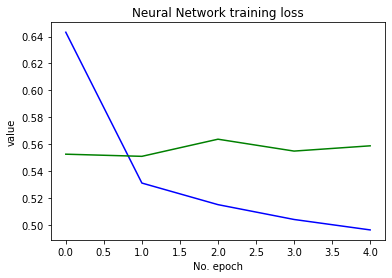

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='(training data)',color='blue')
plt.plot(history.history['val_loss'], label='(val data)',color='green')
plt.title('Neural Network training loss')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

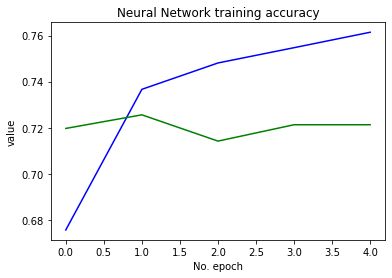

In [32]:
plt.plot(history.history['binary_accuracy'], label='(training data)',color='blue')
plt.plot(history.history['val_binary_accuracy'], label='(val data)',color='green')
plt.title('Neural Network training accuracy')
plt.ylabel('value')
plt.xlabel('No. epoch')
plt.show()

In [33]:
results = model.evaluate(X_test, y_test, batch_size=32)
print("test loss, test acc:", results)

313/313 [==============================] - 1s 4ms/step - loss: 0.5742 - binary_accuracy: 0.7046
test loss, test acc: [0.5741509795188904, 0.7045999765396118]
